In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 새 섹션

In [ ]:


import os
os.makedirs('/content/drive/MyDrive/deep', exist_ok=True)
os.chdir('/content/drive/MyDrive/deep')
print( os.getcwd() )
if not os.path.exists('/content/drive/MyDrive/deep/train.csv'):
    !cp /content/drive/MyDrive/deep/open.zip /content/drive/MyDrive/deep
    !unzip -o -q open.zip
    !rm open.zip
    # 추가 모듈 설치
    !sudo apt-get install -y libmagickwand-dev
    !pip install wandb timm wand

/content/drive/MyDrive/deep


In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from torchvision.transforms import v2
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from transformers import Swinv2Model, ConvNextV2Model, AutoModel
import timm
from PIL import Image

torch.set_float32_matmul_precision('high')  # or 'medium' | 'high'
# os.environ['WANDB_API_KEY']='xxxxx'
# os.environ['WANDB_MODE']='online'
# os.environ['WANDB_PROJECT']='basslibrary240210'
os.environ['WANDB_MODE']='offline'

######## logger ########
import sys, logging, IPython
logger = logging.getLogger()
logging.basicConfig( handlers=[ logging.StreamHandler(stream=sys.stdout), logging.handlers.RotatingFileHandler(filename='run.log', mode='a', maxBytes=512000, backupCount=4) ] )
logging_fomatter = logging.Formatter( '%(asctime)s [%(levelname)-4.4s] %(message)s', datefmt='%m/%d %H:%M:%S' )
_ = [ h.setFormatter(logging_fomatter) for h in logger.handlers ]
logger.setLevel(logging.INFO)
def showtraceback(self, *args, **kwargs):
    logger.exception('-------Exception----------')
IPython.core.interactiveshell.InteractiveShell.showtraceback = showtraceback
logger.info('program started')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
11/19 16:44:26 [INFO] program started


In [ ]:
CFG = {}
CFG['SEED'] = 42
CFG['N_SPLIT'] = 5
CFG['LABEL_SMOOTHING'] = 0.05
CFG['OPTIMIZER'] = 'AdamW'
CFG['INTERPOLATION'] = 'robidouxsharp'
CFG['PRECISION'] = '16'
CFG['MODEL_NAME'] = "timm/eva_large_patch14_336.in22k_ft_in22k_in1k"
CFG['IMG_SIZE'] = 336
CFG['BATCH_SIZE'] = 16
CFG['LR'] = [ 0.25e-5 * np.sqrt(CFG['BATCH_SIZE']), 1e-7 ]
# # ----------------------------------
# # [0. --[9836][9842x2]
# [0.9811,0.9825,0.9811,0.9819,0.9837]
#CFG['MODEL_NAME'] = "timm/eva_large_patch14_196.in22k_ft_in22k_in1k"
#CFG['IMG_SIZE'] = 196
#CFG['IMG_TRAIN_SIZE'] = 196 * 2
#CFG['BATCH_SIZE'] = 48 ## 48/16G(ema), 16/8G
#CFG['LR'] = [ 0.25e-5 * np.sqrt(CFG['BATCH_SIZE']), 1e-6 ]
# # ----------------------------------
# [0.9768, 0.9707, 0.9714, 0.9791, 0.9724 ]
# CFG['MODEL_NAME'] = "timm/convnextv2_large.fcmae_ft_in22k_in1k" ## 288
# # CFG['MODEL_NAME'] = "facebook/convnextv2-large-22k-224"
# CFG['IMG_SIZE'] = 288
# CFG['BATCH_SIZE'] = 16  # 6/8G, 16/16G
# CFG['PRECISION'] = '16'
# CFG['LR'] = [ 0.25e-5 * np.sqrt(CFG['BATCH_SIZE']), 1e-7 ]
# #----------------------------------
# ## best_score=0.9699
# ## A4000: [9737]
# CFG['MODEL_NAME'] = "timm/swinv2_large_window12_192.ms_in22k"
# CFG['IMG_SIZE'] = 192
# CFG['BATCH_SIZE'] = 40 ## 40/16
# CFG['LR'] = 0.25e-5 * np.sqrt(CFG['BATCH_SIZE'])
# # #----------------------------------
# # best_score=0.9805
# [0.9818,0.9815,0.9803,0.9825,0.9813]
# CFG['MODEL_NAME'] = "timm/beitv2_large_patch16_224.in1k_ft_in22k_in1k"
# CFG['IMG_SIZE'] = 224
# CFG['BATCH_SIZE'] = 48 ## 48//16G(ema), 14//8G memory..
# CFG['LR'] = [ 0.25e-5 * np.sqrt(CFG['BATCH_SIZE']), 1e-6 ]
# #----------------------------------
# [0.9742, ]
#CFG['MODEL_NAME'] = "timm/deit3_large_patch16_224.fb_in22k_ft_in1k"    ## 304MB
#CFG['IMG_SIZE'] = 224
#CFG['BATCH_SIZE'] = 48 ## 48//16G, 4//8G memory..
#CFG['LR'] = [ 0.25e-5 * np.sqrt(CFG['BATCH_SIZE']), 1e-7 ]
# #----------------------------------

######################################
if 'IMG_TRAIN_SIZE' not in CFG:
    CFG['IMG_TRAIN_SIZE'] = CFG['IMG_SIZE']
logger.info(CFG)

11/19 16:44:30 [INFO] {'SEED': 42, 'N_SPLIT': 5, 'LABEL_SMOOTHING': 0.05, 'OPTIMIZER': 'AdamW', 'INTERPOLATION': 'robidouxsharp', 'PRECISION': '16', 'MODEL_NAME': 'timm/eva_large_patch14_336.in22k_ft_in22k_in1k', 'IMG_SIZE': 336, 'BATCH_SIZE': 16, 'LR': [1e-05, 1e-07], 'IMG_TRAIN_SIZE': 336}


In [ ]:
assert torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
logger.info(device)

11/19 16:45:28 [INFO] cuda


In [ ]:
def seed_everything(seed):
    logger.info(f'seed_everything : {seed}')

    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

11/19 16:45:29 [INFO] seed_everything : 42


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, load_img_size, shuffle=False, transforms=None, interpolation='robidouxsharp' ):
        self.df = pd.DataFrame({'img_path_list': img_path_list})
        self.interpolation = interpolation
        self.load_img_size = load_img_size
        logger.info(f'load_img_size={load_img_size}')
        if label_list is not None:
            self.df['label_list'] = label_list
        if shuffle:
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)
        self.transforms = transforms

    # numpy or PIL Image => PIL Image
    def get_interpolated_image(self, img, new_image_size):
        if self.interpolation == 'pil_lanczos':
            if isinstance(img, np.ndarray ):
                img = Image.fromarray(img)
            return img.resize( (new_image_size, new_image_size), Image.LANCZOS )
        elif self.interpolation == 'cv2_lanczos4':
            if not isinstance(img, np.ndarray ):
                img = np.array(img)
            import cv2
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img = cv2.resize(src, (new_image_size, new_image_size), interpolation=cv2.INTER_LANCZOS4) # 픽셀 크기 지정
            img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
            return Image.fromarray(img)
        else:
            if not isinstance(img, np.ndarray ):
                img = np.array(img)
            from wand import image
            with image.Image.from_array(img) as src:
                src.resize( new_image_size, new_image_size, filter=self.interpolation )
                return Image.fromarray(np.array(src))

    # path => PIL Image
    def get_image_from_index(self, index, img_size ):
        img_path = self.df.img_path_list[index]
        fname = img_path.replace('./','').split('.')[0] + '.png'
        full_fname = f'img_cached/{img_size}_{self.interpolation}/{fname}'
        if os.path.exists(full_fname):
            img = Image.open(full_fname)
        else:
            fname_path = '/'.join(full_fname.split('/')[:-1])
            os.makedirs(fname_path, exist_ok = True)
            img = self.get_interpolated_image(Image.open(img_path), img_size )
            img.save( full_fname )
        return img

    def __getitem__(self, index):
        image = self.get_image_from_index( index, self.load_img_size )
        if self.transforms is not None:
            image = self.transforms(image)
        if 'label_list' in self.df.columns:
            label = self.df.label_list[index]
            return { 'pixel_values': image, 'label': label }
        else:
            return { 'pixel_values': image }

    def __len__(self):
        return len(self.df)

NameError: name 'Dataset' is not defined

In [ ]:
## ref: https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annealing_warmup/scheduler.py
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 1e-5,
                 min_lr : float = 1e-10,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        # set learning rate min_lr
        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model
        self.clf = nn.LazyLinear(25)

    def forward(self, x):
        x = self.model(x)
        if not isinstance(x, torch.Tensor):
            x = x.pooler_output
        if self.clf:
            x = self.clf(x)
        return x

In [ ]:
train_df = pd.read_csv('./train.csv')
le = LabelEncoder()
train_df['class'] = le.fit_transform(train_df['label'])

In [ ]:
if not len(train_df) == len(os.listdir('./train')):
    raise ValueError()

In [ ]:
skf = StratifiedKFold(n_splits=CFG['N_SPLIT'], random_state=CFG['SEED'], shuffle=True)

In [ ]:
image_size = CFG['IMG_SIZE']

train_transform_list = [
    # v2.RandomHorizontalFlip(), ## eva모델등에서는 성능향상이 없음. 오히려 성능떨어짐.
    v2.TrivialAugmentWide(interpolation=v2.InterpolationMode.BICUBIC),
    v2.RandomErasing(),
    v2.Resize(size=(image_size, image_size), interpolation=v2.InterpolationMode.LANCZOS, antialias=True),
    v2.ToImage(), v2.ToDtype( torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
if CFG['IMG_SIZE'] == CFG['IMG_TRAIN_SIZE']:
    train_transform_list = [ a for a in train_transform_list if not isinstance(a, v2.Resize) ]
train_transform = v2.Compose(train_transform_list )
test_transform = v2.Compose( [
    v2.ToImage(), v2.ToDtype( torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = torch.FloatTensor( compute_class_weight('balanced', classes=train_df.label.sort_values().unique(), y=train_df.label ) )

def train(model, optimizer, train_loader, val_loader, scheduler, device, validation_steps = 0.25, logging_steps = 10, use_amp=True, filename=''):
    logger.info(f'{use_amp=}')

    model.to(device)
    best_score = 0
    best_loss  = 1000
    best_model = None
    MAX_PATIENCE = 5
    best_patience = MAX_PATIENCE
    loss_fn = nn.CrossEntropyLoss( weight=class_weight, label_smoothing=CFG['LABEL_SMOOTHING'], reduction='mean' ).to(device)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    checkpoint_filenames = []

    max_steps = len(train_loader)
    if not isinstance(validation_steps, int):
        validation_steps = int(max_steps * validation_steps)  ## 절사..
    max_steps = (max_steps//validation_steps)*validation_steps

    # ema 모델은 모델의 weight 한벌을 가지고 있어, 메모리 사용량도 확인해야 함..
    ema_model = None  ## 의미가 없을 듯..
    ema_decay = np.power(np.e, np.log(0.5)/(validation_steps*MAX_PATIENCE))
    ema_model = torch.optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(ema_decay))

    for epoch in range(1, 5):
        model.train()
        train_loss = []
        pbar_postfix = {}

        pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
        for i, batch in enumerate(pbar):
            if i >= max_steps:
                continue
            steps = i+1

            if use_amp:
                with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
                    output = model(batch['pixel_values'])
                    loss = loss_fn(output, batch['label'])
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            else:
                output = model(batch['pixel_values'])
                loss = loss_fn(output, batch['label'])
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

            train_loss.append(loss.item())
            loss = None
            output = None
            batch = None

            if ema_model is not None:
                ema_model.update_parameters(model)


            if steps % logging_steps == 0:
                pbar_postfix.update({
                    't_loss0': train_loss[-1],
                    'lr': optimizer.param_groups[0]["lr"]
                } )
                pbar.set_postfix( pbar_postfix )
                run.log({
                    "epoch": epoch,
                    "step": steps,
                    "train":{"loss": train_loss[-1]},
                    "lr": optimizer.param_groups[0]["lr"]
                }, step=(epoch-1)*max_steps+steps)

            if steps % validation_steps == 0:
                _val_loss, _val_score = validation(model, loss_fn, val_loader, device, use_amp)
                _train_loss = np.mean(train_loss)

                best_score_mark = '*' if best_score < _val_score else ' '
                best_loss_mark = '*' if best_loss > _val_loss else ' '
                pbar_postfix.update({
                    'lr': optimizer.param_groups[0]["lr"],
                    't_loss': _train_loss,
                    'v_loss': _val_loss,
                    'v_f1': _val_score
                })
                pbar.set_postfix( pbar_postfix )
                logger.info(f'eps={epoch:d}, lr={optimizer.param_groups[0]["lr"]:.3g}, t_loss={_train_loss:.4f}, v_loss={_val_loss:.4f}{best_loss_mark}, v_f1={_val_score:.4f}{best_score_mark}')
                run.log({
                    "epoch": epoch, "step": steps,
                    "train":{"avg_loss": _train_loss},
                    "valid": { "loss": _val_loss, "score": _val_score},
                    "lr": optimizer.param_groups[0]["lr"]
                }, step=(epoch-1)*max_steps+steps)

                if best_score < _val_score:
                    best_score = _val_score
                    best_model = model
                    best_patience = MAX_PATIENCE
                    ## saving..
                    if filename is not None and len(filename) != 0:
                        checkpoint_filenames.append(
                            filename.format(epoch=epoch, val_loss=_val_loss, val_score=_val_score) + '.ckpt' )
                        if best_score > 0.9600:
                            os.makedirs(os.path.dirname(checkpoint_filenames[-1]), exist_ok=True)
                            torch.save( {"model": model.state_dict() }, checkpoint_filenames[-1] )
                            logger.info( f'{checkpoint_filenames[-1]} : saved.' )
                            _ = [ os.path.exists(fname) and os.remove(fname) for fname in checkpoint_filenames[:-1] ]
                            checkpoint_filenames = checkpoint_filenames[-1:]

                    ## 추가적으로 비교함..
                    if best_loss > _val_loss:
                        best_loss = _val_loss
                elif best_loss > _val_loss:
                    best_loss = _val_loss
                    best_patience = MAX_PATIENCE
                elif best_patience > 0:
                    best_patience -= 1
                else:
                    logger.info(f'NO_MORE_TRAINING, {best_score=:.4f}')
                    if ema_model is not None:
                        # ## EMA --------------------
                        torch.optim.swa_utils.update_bn(train_loader, ema_model, device )
                        ema_val_loss, ema_val_score = validation(ema_model, loss_fn, val_loader, device, use_amp)
                        logger.info(f'EMA ::: ema_v_loss={ema_val_loss:.4f}, ema_v_f1={ema_val_score:.4f}')
                        run.log({'ema_v_loss': ema_val_loss, 'ema_v_f1': ema_val_score })

                        save_filename = filename.format(epoch=epoch, val_loss=ema_val_loss, val_score=ema_val_score) + '-ema.ckpt'
                        torch.save( {"model": ema_model.state_dict() }, save_filename )
                        logger.info( f'{save_filename} : (ema) saved.' )
                        # ##========================
                    if not os.path.exists(checkpoint_filenames[-1]):
                        os.makedirs(os.path.dirname(checkpoint_filenames[-1]), exist_ok=True)
                        torch.save( {"model": best_model.state_dict() }, checkpoint_filenames[-1] )
                        logger.info( f'{checkpoint_filenames[-1]} : saved.' )
                        _ = [ os.path.exists(fname) and os.remove(fname) for fname in checkpoint_filenames[:-1] ]
                        checkpoint_filenames = checkpoint_filenames[-1:]
                    return best_model

In [ ]:
def validation(model, loss_fn, val_loader, device, use_amp):
    model = model.to(device)
    save_training = model.training
    model.eval()

    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            true_labels += batch['label'].detach().cpu().numpy().tolist()
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
                pred = model(batch['pixel_values'])
                loss = loss_fn(pred, batch['label'])
            preds += pred.detach().argmax(1).cpu().numpy().tolist()
            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='macro')
    ## return_to_train..
    if save_training:
        model.train()
    return _val_loss, _val_score

In [ ]:
def prediction(model, test_loader, device):
    model = model.to(device)
    save_training = model.training
    model.eval()
    preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            pred = model(pixel_values)  ## F.softmax(output) ## 의미는 없을 듯.
            preds += pred.detach().cpu().numpy().tolist()
    if save_training:
        model.train()
    return preds

In [ ]:
def create_model(model_name):
    import timm
    from transformers import AutoModel, AutoModelForImageClassification, AutoConfig

    logger.info(f'create_model: {model_name}')
    if '/' not in model_name:
        model_name = 'timm/' + model_name

    if model_name.startswith('./'):
        import nextvit
        model = CustomModel( timm.create_model('nextvit_large', pretrained=True, checkpoint_path=model_name) )
    elif model_name.startswith('facebook/hiera_'):
        from hiera import Hiera  ## pip install hiera-transformer
        model = CustomModel( Hiera.from_pretrained(model_name) )
    elif model_name.startswith('timm/'):
        model = CustomModel( timm.create_model( model_name, pretrained=True ) )
    else:
        model = CustomModel( AutoModel.from_pretrained(model_name) )
    model.eval()
    model( torch.rand((1,3,CFG['IMG_SIZE'],CFG['IMG_SIZE'])).type(torch.float32) ) ## initalize_lazyLinear..
    return model

# 모델 훈련

In [ ]:
from datetime import datetime
dt_str = datetime.now().strftime('%m%d%H%M')

for fold_idx, (train_index, val_index) in enumerate(skf.split(train_df, train_df['class'])):
    gc.collect()
    torch.cuda.empty_cache()

    logger.info(f'{fold_idx=} started')
    import wandb
    run = wandb.init(
        name=f'fold{fold_idx+1}_{CFG["MODEL_NAME"].split("/")[1].split("-")[0]}_{dt_str}',
        config=CFG,
        reinit=True)

    train_fold_df = train_df.loc[train_index,:]
    val_fold_df = train_df.loc[val_index,:]

    train_dataset = CustomDataset(
        train_fold_df['img_path'].values, train_fold_df['class'].values,
        interpolation=CFG['INTERPOLATION'], load_img_size=CFG['IMG_TRAIN_SIZE'],
        shuffle=True, transforms=train_transform)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, generator=torch.Generator(device=device), num_workers=0)
    val_dataset = CustomDataset(
        val_fold_df['img_path'].values,
        val_fold_df['class'].values,
        interpolation=CFG['INTERPOLATION'], load_img_size=CFG['IMG_SIZE'],
        shuffle=False, transforms=test_transform)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE']*2, shuffle=False, generator=torch.Generator(device=device), num_workers=0)

    model = create_model(CFG['MODEL_NAME'])

    ## wrapp model
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CFG['LR'][0],
        weight_decay=0.001,  ## default는 0.01이며, 논문은 0.001임.
    )
    scheduler = None
    scheduler = CosineAnnealingWarmupRestarts(
        optimizer,
        first_cycle_steps=int( len(train_loader) ) // 4,
        cycle_mult=1.0, max_lr=CFG['LR'][0] * 2,
        min_lr=CFG['LR'][1],
        warmup_steps=0,
        gamma=0.93,  ## 2024.05.02
    )

    model = train(
        model, optimizer, train_loader, val_loader, scheduler, device,
        use_amp=(CFG['PRECISION'] == '16'),
        filename = f'./ckpt/{CFG["MODEL_NAME"].split("/")[1].split("-")[0]}-fold_idx={fold_idx}-' + 'epoch={epoch:02d}-val_loss={val_loss:.4f}-val_score={val_score:.4f}',
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()
    logger.info(f'{fold_idx=} finished')
    run.finish()

    try:
        # !python ~/send_telegram.py 'fold_idx={fold_idx} finished'
        last_chpt_info = !ls -t ./ckpt/ | head -n1
        last_chpt_info = ','.join( last_chpt_info[0][:-5].split('-')[1:] )
        !python ~/send_telegram.py {last_chpt_info}
    except:
        pass

11/19 07:49:28 [INFO] fold_idx=0 started
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


11/19 07:49:31 [INFO] load_img_size=392
11/19 07:49:31 [INFO] load_img_size=196
11/19 07:49:31 [INFO] create_model: timm/eva_large_patch14_196.in22k_ft_in22k_in1k
11/19 07:49:32 [INFO] Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_196.in22k_ft_in22k_in1k)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

11/19 07:49:39 [INFO] [timm/eva_large_patch14_196.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
11/19 07:49:41 [INFO] use_amp=True
<ipython-input-14-db161cb0e4cf>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epoch 1:   0%|          | 0/264 [00:00<?, ?it/s]

11/19 07:49:42 [ERRO] -------Exception----------
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-19ea94761746>", line 48, in <cell line: 4>
    model = train(
  File "<ipython-input-14-db161cb0e4cf>", line 33, in train
    for i, batch in enumerate(pbar):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 250, in __iter__
    for obj in it:
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 757, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-pack

# 모델 앙상블 및 추론

In [ ]:
# colab 기준으로 돌리는 경우, 아래처럼 라이브러리를 설치해주셔야 합니다.
# 코드는 RTX-A4000 환경이었는데, T4에서 잘될지 모르겠네요.
# A100이나 V100에서 돌리길 권장합니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_df = pd.read_csv('./test.csv')

In [ ]:
import re
ckpt_df = pd.DataFrame({'fname':glob('./ckpt/*.ckpt')})
ckpt_df['mtime'] = ckpt_df.fname.apply(lambda x: int(os.stat(x).st_mtime))
ckpt_df['model_name'] = ckpt_df.fname.apply(lambda x: re.search(r'./ckpt/(.*?)-fold',x)[1])
ckpt_df['img_size'] = ckpt_df.fname.apply(lambda x: int(re.search(r'patch[0-9]+_([0-9]+)', x + 'patch0_0')[1]) )
ckpt_df['is_ema'] = ckpt_df.fname.str.endswith('ema.ckpt').astype(int)
ckpt_df['fold_idx'] = ckpt_df.fname.apply(lambda x: int(re.search(r'fold_idx=([0-9])-',x)[1]))
ckpt_df['val_loss'] = ckpt_df.fname.apply(lambda x: float(re.search(r'val_loss=(0\.[0-9]+)', x)[1]) )
ckpt_df['val_score'] = ckpt_df.fname.apply(lambda x: float(re.search(r'val_score=(0\.[0-9]+)', x)[1]) )

In [ ]:
ckpt_df = ckpt_df[ckpt_df.img_size != 0][ckpt_df.is_ema == 0]
ckpt_df = ckpt_df.sort_values('mtime',ascending=False).reset_index(drop=True)
ckpt_indexes = ckpt_df[ ckpt_df.fold_idx==ckpt_df.fold_idx.max() ].index[:4]

In [ ]:
preds = []
preds_score = []

for ckpt_start_index in ckpt_indexes:
    logger.info(f'{ckpt_df.fname[ckpt_start_index]} loading')
    ## imagesize
    CFG['IMG_SIZE'] = ckpt_df.img_size[ckpt_start_index]
    assert CFG['IMG_SIZE'] in ( 196, 336, )
    logger.info(CFG['IMG_SIZE'])

    test_dataset = CustomDataset(
        test_df['img_path'].values, None,
        interpolation=CFG['INTERPOLATION'], load_img_size=CFG['IMG_SIZE'],
        shuffle=False, transforms=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE']*2, shuffle=False, num_workers=0)


    model_name = ckpt_df.model_name[ckpt_start_index]
    model = create_model(model_name)
    if ckpt_df.is_ema[ckpt_start_index]:
        model = torch.optim.swa_utils.AveragedModel(model)
    #-----------------------------
    for i in range(ckpt_start_index, ckpt_start_index + ckpt_df.fold_idx.max() + 1 ):
        checkpoint_path = ckpt_df.fname[i]
        logger.info(f'{checkpoint_path} loading')
        model.load_state_dict( torch.load(checkpoint_path)['model'] )

        preds_score.append( ckpt_df.val_score[i] )
        preds.append( prediction(model, test_loader, device) )

preds = np.array(preds)
preds_score = np.array(preds_score)

11/19 16:46:09 [INFO] ./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k-fold_idx=4-epoch=04-val_loss=0.4105-val_score=0.9803.ckpt loading
11/19 16:46:09 [INFO] 336
11/19 16:46:09 [INFO] load_img_size=336
11/19 16:46:09 [INFO] create_model: eva_large_patch14_336.in22k_ft_in22k_in1k
11/19 16:46:10 [INFO] Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

11/19 16:46:17 [INFO] [timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
11/19 16:46:18 [INFO] ./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k-fold_idx=4-epoch=04-val_loss=0.4105-val_score=0.9803.ckpt loading
<ipython-input-25-d0b234b29d71>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializatio

  0%|          | 0/213 [00:00<?, ?it/s]

11/19 17:20:12 [INFO] ./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k-fold_idx=3-epoch=03-val_loss=0.4086-val_score=0.9796.ckpt loading


  0%|          | 0/213 [00:00<?, ?it/s]

11/19 17:32:46 [INFO] ./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k-fold_idx=2-epoch=04-val_loss=0.4220-val_score=0.9788.ckpt loading


  0%|          | 0/213 [00:00<?, ?it/s]

11/19 17:45:18 [INFO] ./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k-fold_idx=1-epoch=04-val_loss=0.4117-val_score=0.9787.ckpt loading


  0%|          | 0/213 [00:00<?, ?it/s]

11/19 17:57:52 [INFO] ./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k-fold_idx=0-epoch=04-val_loss=0.4057-val_score=0.9824.ckpt loading


  0%|          | 0/213 [00:00<?, ?it/s]

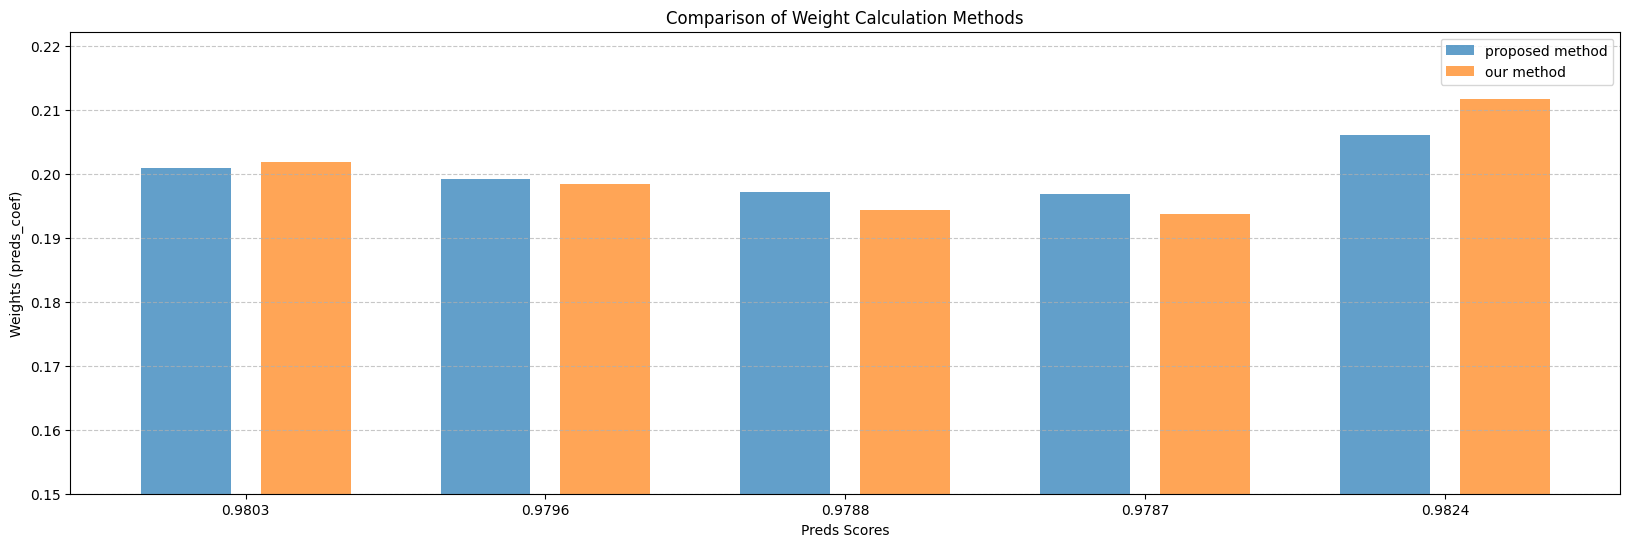

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 예제 데이터
preds_score = np.array([0.9803, 0.9796, 0.9788, 0.9787, 0.9824])  # 가중치 계산에 사용할 스코어

# 첫 번째 코드의 가중치 계산
preds_error1 = (1 - preds_score)
preds_error1 = 1 - preds_error1 / preds_error1.sum()
preds_coef1 = preds_error1 / preds_error1.sum()

# 두 번째 코드의 가중치 계산
preds_error2 = (1 - preds_score) ** 2
preds_coef2 = (1 - preds_error2 / preds_error2.sum())
preds_coef2 /= preds_coef2.sum()

# 가중치 시각화
x = np.arange(len(preds_score))
plt.figure(figsize=(20, 6))

plt.bar(x - 0.2, preds_coef1, width=0.3, label='proposed method', alpha=0.7)
plt.bar(x + 0.2, preds_coef2, width=0.3, label='our method', alpha=0.7)

# 그래프 설정
plt.xticks(x, [f'{score:.4f}' for score in preds_score])  # 각 스코어를 x축 레이블로 사용
plt.xlabel('Preds Scores')
plt.ylabel('Weights (preds_coef)')
plt.title('Comparison of Weight Calculation Methods')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# y축 범위 설정 (시작점을 0.1로 설정)
plt.ylim(0.15, max(np.max(preds_coef1), np.max(preds_coef2)) * 1.05)

# 그래프 출력
plt.show()


In [ ]:
preds_error = (1-preds_score)
preds_error = 1-preds_error/preds_error.sum()
preds_coef = preds_error/preds_error.sum()

logger.info(f'{preds_score=}')
logger.info(f'{preds_coef=}')
preds2 = np.array( [ coef * preds[i] for i, coef in enumerate( preds_coef ) ] )
preds_labels = le.inverse_transform(preds2.sum(0).argmax(-1))


11/19 18:10:29 [INFO] preds_score=array([0.9803, 0.9796, 0.9788, 0.9787, 0.9824])
11/19 18:10:29 [INFO] preds_coef=array([0.2008483 , 0.1991018 , 0.19710579, 0.19685629, 0.20608782])


In [ ]:
preds_error = (1 - preds_score) ** 2
preds_coef = (1 - preds_error / preds_error.sum())
preds_coef /= preds_coef.sum()

logger.info(f'{preds_score=}')
logger.info(f'{preds_coef=}')

preds2 = np.array([coef * preds[i] for i, coef in enumerate(preds_coef)])
preds_labels = le.inverse_transform(preds2.sum(0).argmax(-1))


11/18 19:27:54 [INFO] preds_score=array([0.9803, 0.9796, 0.9788, 0.9787, 0.9824])
11/18 19:27:54 [INFO] preds_coef=array([0.20190096, 0.19842202, 0.19429737, 0.19377064, 0.21160901])


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = preds_labels
from datetime import datetime
dt_str = datetime.now().strftime('%Y%m%d_%H%M')
submit.to_csv(f'./basslibrary_submit_{dt_str}.csv', index=False)
logger.info(f'./basslibrary_submit_{dt_str}.csv saved')

11/18 19:28:27 [INFO] ./basslibrary_submit_20241118_1928.csv saved


In [ ]:
submit.label.value_counts()

,count
label,
Asian Green Bee-Eater,310
House Crow,305
Common Myna,297
Forest Wagtail,295
Hoopoe,289
Indian Roller,282
Brown-Headed Barbet,282
Indian Peacock,282
White-Breasted Waterhen,280
